# KRL for BeatAML2

At this point we are going to perform KRL using beatAML datasets. The first point would then be to load the required libraries

In [1]:
import os
import sys
import yaml
import argparse
import numpy as np
import scipy.io as sio 
import pandas as pd
import time

from misc import read_FULL, read_KEEPK, read_SAMPLE
from misc import FULL, SAMPLE, KEEPK
from misc import GEX, WES, CNV, METH
from misc import KRL as KRL_STR
from misc import LKRL as LKRL_STR
from misc import KBMTL as KBMTL_STR
from misc import KRR as KRR_STR
from misc import RF as RF_STR
from misc import EN as EN_STR
from results import get_result_filename
from baseline.baseline import KRR, EN, RF

from KRL.KRL import KRL

In [2]:
os.getcwd()

'C:\\Users\\ksada\\OneDrive - Tecnun\\interpretable-ai-review\\KRL\\KRL\\KernelizedRankLearningmaster'

## Import BeatAML dataset

We will now read the csv files generated from the pre-processing step in R

In [3]:
mut2=pd.read_csv("./../../../data/input/mutations_w12L_NAs.csv",delimiter=",")
drug=pd.read_csv("./../../../data/input/drug_matrix_KRL_w12_NAs.csv",delimiter=",",decimal=".")

drug.head(10)

,Unnamed: 0,Axitinib (AG-013736),Crenolanib,Crizotinib (PF-2341066),Dasatinib,Erlotinib,Gefitinib,Ibrutinib (PCI-32765),Imatinib,Lapatinib,...,Volasertib (BI-6727),Gilteritinib,Lenalidomide,OTX-015,Palbociclib,Panobinostat,SR9011,Artemisinin,Entrectinib,Selinexor
0,2489,2.265193,2.084471,1.542583,2.302439,1.875024,2.040741,NaN,2.042441,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2034,1.560540,1.725416,1.542583,1.167739,1.875024,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2469,1.560540,1.725416,1.542583,1.167739,1.875024,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2378,1.560540,1.725416,2.828768,3.241933,1.875024,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2466,1.560540,1.725416,1.542583,1.167739,1.875024,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2298,1.560540,1.725416,1.542583,1.167739,2.191703,2.040741,1.550924,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2407,2.401485,1.725416,1.919963,2.428865,1.875024,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2278,2.146285,1.725416,2.256399,2.514767,2.894352,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2239,1.560540,1.725416,1.542583,1.167739,3.333579,2.040741,NaN,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2173,1.560540,1.725416,1.542583,1.167739,1.875024,2.040741,1.550924,1.924699,1.981862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mut2.head(5)

,Unnamed: 0,CEBPA,FLT3,SRSF2,ASXL1,TP53,KRAS,WT1,STAG2,SUZ12,...,MYT1,KRTAP4-5,SUCO,BRAF,NEO1,ZIC3,CBFB-MYH11,RPN1-EVI1,RUNX1-RUNX1T1,MLLT3-MLL
0,2489,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2034,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2469,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2378,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
mut2=mut2.set_index('Unnamed: 0')
drug=drug.set_index('Unnamed: 0')
drug=drug.astype(float, copy=True)

In [8]:
drug.dtypes

Axitinib (AG-013736)        float64
Crenolanib                  float64
Crizotinib (PF-2341066)     float64
Dasatinib                   float64
Erlotinib                   float64
Gefitinib                   float64
Ibrutinib (PCI-32765)       float64
Imatinib                    float64
Lapatinib                   float64
Nilotinib                   float64
Pazopanib (GW786034)        float64
Ponatinib (AP24534)         float64
Quizartinib (AC220)         float64
Ruxolitinib (INCB018424)    float64
Sorafenib                   float64
Sunitinib                   float64
Bortezomib (Velcade)        float64
Rapamycin                   float64
Vandetanib (ZD6474)         float64
AZD1152-HQPA (AZD2811)      float64
Alisertib (MLN8237)         float64
CYT387                      float64
Canertinib (CI-1033)        float64
Doramapimod (BIRB 796)      float64
Dovitinib (CHIR-258)        float64
Flavopiridol                float64
GDC-0941                    float64
GW-2580                     

We will now divide in 5 folds the different samples to test the accuracy of the method for cross-validation and we will compare it against the Oracle.

The function `arg.max()` seems a better option for selecting the recommended drugs. Meaning that the maximum value in the predictions is the best drug for the patient.

FINAL MODEL AFTER HYPERPARAMETER TUNNING

### 5-fold Cross-Validation

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True)

Res={}
res=[]
for train_index, test_index in cv.split(mut2):
    X_train=mut2.iloc[train_index,:].to_numpy()
    X_test=mut2.iloc[test_index, :].to_numpy()
    y_train=drug.iloc[train_index,:].to_numpy()
    y_test=drug.iloc[test_index,:].to_numpy()
    st = time.time()
    Y_pred_cv=KRL(X_train, y_train, X_test,  5,0.01, 0.01, 8, verbose=True)
    
    et = time.time()
    elapsed_time=et-st
    print('Execution time:', elapsed_time, 'seconds')
    Res['train_index']=train_index
    Res['test_index']=test_index
    Res['Predictions']=Y_pred_cv
    res.append(Res)


Epsilon iter 1: 1076693.43489
Epsilon iter 2: 228869.941277
Epsilon iter 3: 82435.5476784
Epsilon iter 4: 37427.2012658
Epsilon iter 5: 17305.3224906
Epsilon iter 6: 8872.26659321
Epsilon iter 7: 4967.7348825
Epsilon iter 8: 3325.76461786
Epsilon iter 9: 2349.44663913
Epsilon iter 10: 1808.25859023
Epsilon iter 11: 1684.24086704
Epsilon iter 12: 1654.68143728
Epsilon iter 13: 1638.78068731
Epsilon iter 14: 1629.41278674
Epsilon iter 15: 1584.75673907
Epsilon iter 16: 1487.24301757
Epsilon iter 17: 1463.98187775
Epsilon iter 18: 1449.5110974
Epsilon iter 19: 1438.73674501
Epsilon iter 20: 1430.48288551
Epsilon iter 21: 1304.48455143
Epsilon iter 22: 561.164466329
Epsilon iter 23: 149.922262898
Epsilon iter 24: 54.3685716473
Epsilon iter 25: 30.1062102593
Epsilon iter 26: -21.7548363199
('Execution time:', 874.6180000305176, 'seconds')
Epsilon iter 1: 1084771.86218
Epsilon iter 2: 230519.488935
Epsilon iter 3: 87498.077021
Epsilon iter 4: 38204.7609712
Epsilon iter 5: 19163.6387506
Epsil

In [56]:
len(mut2)

247

In [51]:
Results_cv=pd.DataFrame(columns=['Patients' , 'Drug'])
patients=pd.Series(drug.index)

for i in range(len(res)):
    drugs=np.argmax(res[i]['Predictions'], axis=1)
    pat_names=patients.iloc[res[i]['test_index']]
    Results_cv=pd.concat([Results_cv,pd.DataFrame({'Patients': pat_names, 'Drug': drugs})], ignore_index=True, sort=True)
    
drug_names=drug.columns.values.tolist()
indexes=Results_cv['Drug'].values.tolist()
indexes=[int(i) for i in indexes]

for i in range(len(indexes)):
    Results_cv.loc[i,'DrugName']=drug_names[indexes[i]]

Results_cv

,Drug,Patients,DrugName
0,67,2407,JNJ-28312141
1,23,2015,Doramapimod (BIRB 796)
2,114,2290,Panobinostat
3,2,2245,Crizotinib (PF-2341066)
4,93,2128,Trametinib (GSK1120212)
5,115,2186,SR9011
6,115,2212,SR9011
7,114,2576,Panobinostat
8,108,2017,Venetoclax
9,114,2227,Panobinostat


In [53]:
len(Results_cv)

245

In [52]:
Results_cv.to_csv("./../../../data/output/KRL_results_5cv_BeatAML2.csv", index=False)

### All Data Model (train with waves 1+2, test with waves 3+4)

In [62]:
mut_test=pd.read_csv("./../../../data/input/mutations_w34_NAs.csv",delimiter=",")
mut_test = mut_test.set_index('Unnamed: 0')

In [92]:
# st=time.time()
# Y_pred_full=KRL(mut2.to_numpy(), drug.to_numpy(), mut_test.to_numpy(),  5, 0.01,0.01, 8, verbose=True)
# et=time.time()
# elapsed_time=et-st
# print('Execution time:', elapsed_time, 'seconds')

In [91]:
from KRL.KRL import KRL_fit, KRL_pred
st=time.time()
KRL_model=KRL_fit(mut2.to_numpy(), drug.to_numpy(),  5, 0.01,0.01, 8, verbose=True)
et=time.time()
elapsed_time=et-st
print('Execution time:', elapsed_time, 'seconds')

Epsilon iter 1: 1739336.8259
Epsilon iter 2: 367595.496345
Epsilon iter 3: 137039.544942
Epsilon iter 4: 57612.0543554
Epsilon iter 5: 30810.0837216
Epsilon iter 6: 13940.2302479
Epsilon iter 7: 7096.95865668
Epsilon iter 8: 3991.57657566
Epsilon iter 9: 2713.60358981
Epsilon iter 10: 2340.83039267
Epsilon iter 11: 2193.54399736
Epsilon iter 12: 2142.90719994
Epsilon iter 13: 2120.27465914
Epsilon iter 14: 2094.1110097
Epsilon iter 15: 2006.60608505
Epsilon iter 16: 1878.27379475
Epsilon iter 17: 1859.07987731
Epsilon iter 18: 1850.53912296
Epsilon iter 19: 1841.05439619
Epsilon iter 20: 1814.53690393
Epsilon iter 21: 1786.54761906
Epsilon iter 22: 1765.69545947
Epsilon iter 23: 1752.18641829
Epsilon iter 24: 1743.40301994
Epsilon iter 25: 1739.78514557
Epsilon iter 26: 1376.22487617
Epsilon iter 27: 585.218109348
Epsilon iter 28: 368.949710609
Epsilon iter 29: 71.5498074012
Epsilon iter 30: -35.8050613433
('Execution time:', 1292.00200009346, 'seconds')


In [95]:
Y_pred_full = KRL_pred(KRL_model, mut2.to_numpy(), mut_test.to_numpy(), 0.01)

In [96]:
Results_all=pd.DataFrame({'Patients':pd.Series(mut_test.index), 'Best Drug': np.argmax(Y_pred_full, axis=1)})
drug_names=drug.columns.values.tolist()
indexes=Results_all['Best Drug'].values.tolist()
indexes=[int(i) for i in indexes]


for i in range(len(indexes)):
    Results_all.loc[i,'DrugName']=drug_names[indexes[i]]

Results_all

,Best Drug,Patients,DrugName
0,12,2606,Quizartinib (AC220)
1,90,2777,Selumetinib (AZD6244)
2,17,2729,Rapamycin
3,108,2664,Venetoclax
4,56,2830,BMS-345541
5,114,2827,Panobinostat
6,90,2709,Selumetinib (AZD6244)
7,17,2668,Rapamycin
8,52,2624,AT7519
9,108,2811,Venetoclax


In [98]:
Results_all.to_csv("./../../../data/output/KRL_results_w34_BeatAML2.csv", index=False)

## Predict with GDSC

In [100]:
mut_GDSC=pd.read_csv("./../../../data/input/mutations_AML_GDSC_NAs.csv",delimiter=",")
mut_GDSC = mut_GDSC.set_index('Unnamed: 0')

In [102]:
Y_pred_GDSC=KRL_pred(KRL_model, mut2.to_numpy(), mut_GDSC.to_numpy(), 0.01)

In [103]:
Results_GDSC=pd.DataFrame({'CLs':pd.Series(mut_GDSC.index), 'Best Drug': np.argmax(Y_pred_GDSC, axis=1)})

drug_names=drug.columns.values.tolist()
indexes=Results_GDSC['Best Drug'].values.tolist()
indexes=[int(i) for i in indexes]


for i in range(len(indexes)):
    Results_GDSC.loc[i,'DrugName']=drug_names[indexes[i]]

Results_GDSC

,Best Drug,CLs,DrugName
0,90,OCIAML3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Selumetinib (AZD6244)
1,90,NB4_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Selumetinib (AZD6244)
2,90,ME1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Selumetinib (AZD6244)
3,108,MOLM13_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Venetoclax
4,52,MOLM16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,AT7519
5,25,OCIAML5_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Flavopiridol
6,43,OCIM1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,STO609
7,90,PL21_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Selumetinib (AZD6244)
8,51,CTV1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ABT-737
9,90,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Selumetinib (AZD6244)


In [104]:
Results_GDSC.to_csv("./../../../data/output/KRL_results_GDSC.csv", index=False)

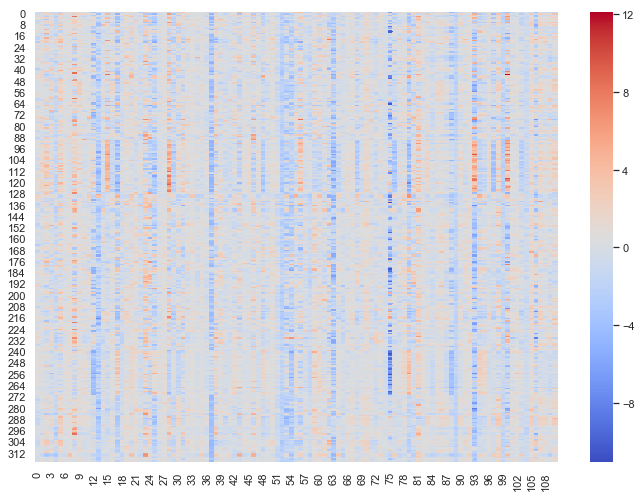

In [251]:
import seaborn as sns

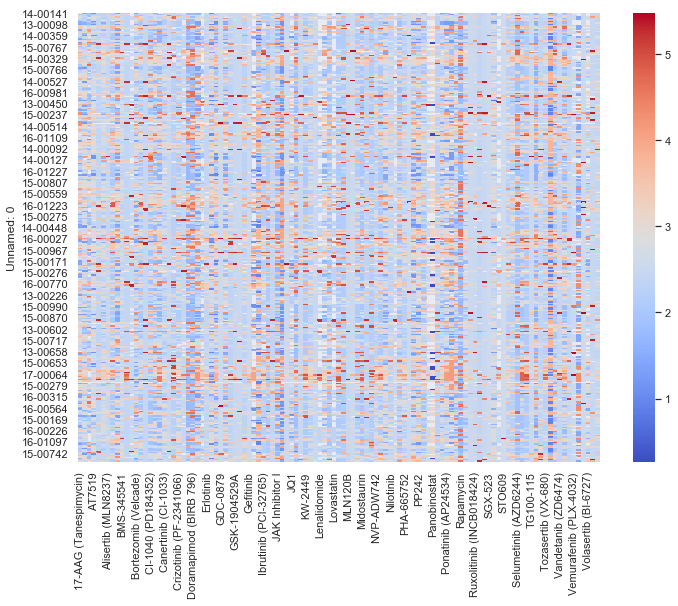

In [252]:
sns.heatmap(drug, cmap='coolwarm')

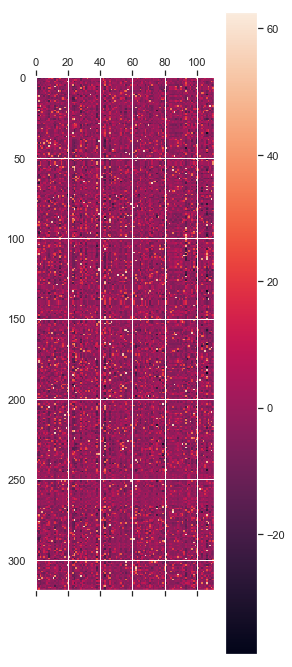

In [233]:
W
import matplotlib.pyplot as plt

plt.matshow(W)
plt.colorbar()
plt.show()